## This code tests how BDT detects anomalies in simulated timeseries

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)  

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score

from sklearn import tree

from sklearn.metrics import roc_curve, auc
#from sklearn.preprocessing import LabelBinarizer

from pandas.tseries.offsets import *

import simulated_dataOriginal
# from graphviz import Source

#### parameters to set

In [3]:
# tuning parameters
cut = 0.55
window = 24

#### generate data

In [4]:
df =  simulated_dataOriginal.get_simulated_data()
# df =  simulated_dataOriginal.get_simulated_fixed_data()
df.head()

affected: [2 5] 2017-08-03 07:36:42 2017-08-03 07:58:06
affected: [2 0 1 4] 2017-08-01 06:23:52 2017-08-01 07:06:09
affected: [1 3 2 4 5] 2017-08-05 18:30:38 2017-08-05 19:24:01
affected: [5 2 3] 2017-08-02 11:27:58 2017-08-02 12:21:16
affected: [2 1 4 0 5] 2017-08-05 07:20:14 2017-08-05 10:35:35
affected: [3 1] 2017-08-03 19:20:06 2017-08-03 20:17:46


,link 0,link 1,link 2,link 3,link 4,link 5,flag
2017-08-01 00:00:00,0.234309,0.098391,0.546828,0.290921,0.403015,0.245851,0
2017-08-01 00:00:01,0.230034,0.134577,0.548541,0.288414,0.399936,0.238371,0
2017-08-01 00:00:02,0.225711,0.127967,0.539710,0.287345,0.393710,0.243551,0
2017-08-01 00:00:03,0.231239,0.127110,0.543637,0.283620,0.401527,0.236844,0
2017-08-01 00:00:04,0.231674,0.141980,0.546474,0.290413,0.396456,0.235442,0


#### plot timeseries

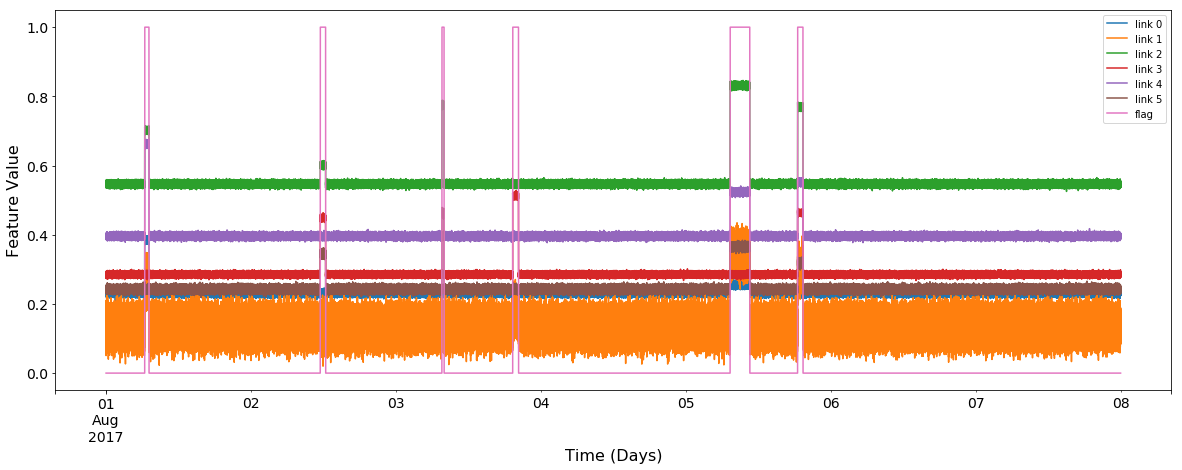

In [5]:
ax = df.plot(figsize=(20,7))
ax.set_xlabel("Time (Days)", fontsize=16)
ax.set_ylabel("Feature Value", fontsize=16)

#### functions

In [6]:
def check_for_anomaly(ref, sub):
    
    y_ref = pd.Series([0] * ref.shape[0])
    X_ref = ref
    del X_ref['flag']
    del X_ref['auc_score']
    del X_ref['accuracy']
    
    y_sub = pd.Series([1] * sub.shape[0])
    X_sub=sub
    del X_sub['flag']
    del X_sub['auc_score']
    del X_sub['accuracy']
    
    # separate Reference and Subject into Train and Test
    X_ref_train, X_ref_test, y_ref_train, y_ref_test = train_test_split(X_ref, y_ref, test_size=0.3, random_state=42)
    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)
    
    # combine training ref and sub samples
    X_train = pd.concat([X_ref_train, X_sub_train])
    y_train = pd.concat([y_ref_train, y_sub_train])

    # combine testing ref and sub samples
    X_test = pd.concat([X_ref_test, X_sub_test])
    y_test = pd.concat([y_ref_test, y_sub_test])
    
#     dtc=DecisionTreeClassifier()
    clf = AdaBoostClassifier() #dtc
#     clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),algorithm="SAMME",n_estimators=200)
    
    #train an AdaBoost model to be able to tell the difference between the reference and subject data
    clf.fit(X_train, y_train) 

    #Predict using the combined test data
    y_predict = clf.predict(X_test)
    
    # scores = cross_val_score(clf, X, y)
    # print(scores)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_predict) # calculate the false positive rate and true positive rate
    auc_score = auc(fpr, tpr) #calculate the AUC score
    
    accuracyscore = accuracy_score(y_test, y_predict) #calculate the Accuracy 
    print ("accuracy = ", accuracyscore)
    
    print ("auc_score = ", auc_score, "\tfeature importances:", clf.feature_importances_)
    
    if auc_score > cut: 
         plot_roc(fpr, tpr, auc_score)
#         filename='tree_'+sub.index.min().strftime("%Y-%m-%d_%H")
#         tree.export_graphviz(clf.estimators_[0] , out_file=filename +'_1.dot') 
#         tree.export_graphviz(clf.estimators_[1] , out_file=filename +'_2.dot') 
        
    return auc_score, accuracyscore

In [7]:
def plot_roc(fpr,tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], linestyle='--', color='r',label='Luck', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

#### Looping over time intervals

accuracy =  0.96
auc_score =  0.5 	feature importances: [0.16 0.08 0.22 0.06 0.24 0.24]
2017-08-02 01:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
accuracy =  0.96
auc_score =  0.5 	feature importances: [0.22 0.04 0.2  0.3  0.2  0.04]
2017-08-02 02:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
accuracy =  0.9598518518518518
auc_score =  0.49992283950617283 	feature importances: [0.04 0.2  0.24 0.1  0.22 0.2 ]
2017-08-02 03:00:00 	refes: 86400 	subjects: 3600 	auc: 0.49992283950617283
accuracy =  0.959962962962963
auc_score =  0.4999807098765432 	feature importances: [0.28 0.14 0.1  0.16 0.22 0.1 ]
2017-08-02 04:00:00 	refes: 86400 	subjects: 3600 	auc: 0.4999807098765432
accuracy =  0.96
auc_score =  0.5 	feature importances: [0.12 0.26 0.18 0.18 0.1  0.16]
2017-08-02 05:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
accuracy =  0.960037037037037
auc_score =  0.500462962962963 	feature importances: [0.16 0.16 0.2  0.18 0.22 0.08]
2017-08-02 06:00:00 	refes: 86400 	subjects: 3600 	auc: 

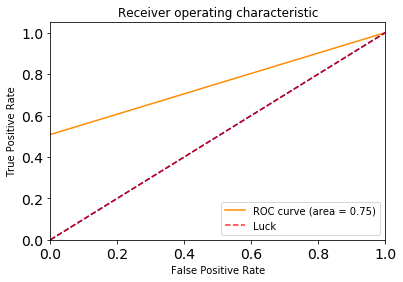

2017-08-02 12:00:00 	refes: 86400 	subjects: 3600 	auc: 0.7541666666666667
accuracy =  0.9601851851851851
auc_score =  0.507638888888889 	feature importances: [0.18 0.12 0.22 0.2  0.12 0.16]
2017-08-02 13:00:00 	refes: 86400 	subjects: 3600 	auc: 0.507638888888889
accuracy =  0.96
auc_score =  0.5 	feature importances: [0.16 0.14 0.2  0.22 0.16 0.12]
2017-08-02 14:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
accuracy =  0.959962962962963
auc_score =  0.4999807098765432 	feature importances: [0.26 0.14 0.1  0.12 0.16 0.22]
2017-08-02 15:00:00 	refes: 86400 	subjects: 3600 	auc: 0.4999807098765432
accuracy =  0.959962962962963
auc_score =  0.4999807098765432 	feature importances: [0.22 0.1  0.26 0.12 0.08 0.22]
2017-08-02 16:00:00 	refes: 86400 	subjects: 3600 	auc: 0.4999807098765432
accuracy =  0.96
auc_score =  0.5 	feature importances: [0.24 0.18 0.2  0.1  0.22 0.06]
2017-08-02 17:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
accuracy =  0.96
auc_score =  0.5 	feature importances: [

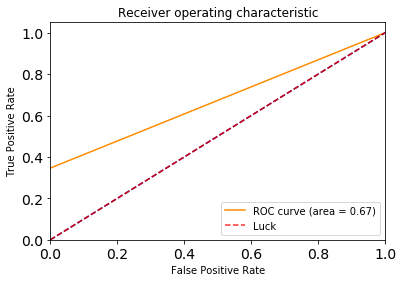

2017-08-03 08:00:00 	refes: 86400 	subjects: 3600 	auc: 0.6731481481481482
accuracy =  0.96
auc_score =  0.5 	feature importances: [0.16 0.14 0.16 0.16 0.12 0.26]
2017-08-03 09:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
accuracy =  0.96
auc_score =  0.5 	feature importances: [0.16 0.16 0.18 0.18 0.08 0.24]
2017-08-03 10:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
accuracy =  0.96
auc_score =  0.5 	feature importances: [0.2  0.22 0.16 0.08 0.08 0.26]
2017-08-03 11:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
accuracy =  0.9597777777777777
auc_score =  0.4998842592592593 	feature importances: [0.16 0.28 0.16 0.12 0.12 0.16]
2017-08-03 12:00:00 	refes: 86400 	subjects: 3600 	auc: 0.4998842592592593
accuracy =  0.96
auc_score =  0.5 	feature importances: [0.3  0.12 0.12 0.16 0.16 0.14]
2017-08-03 13:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
accuracy =  0.96
auc_score =  0.5 	feature importances: [0.12 0.1  0.12 0.2  0.14 0.32]
2017-08-03 14:00:00 	refes: 86400 	subjects: 3600 	au

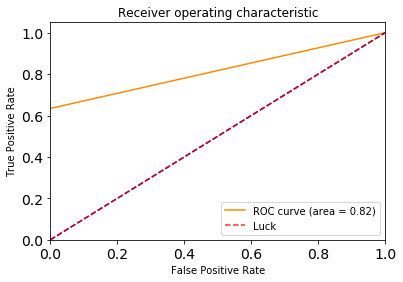

2017-08-03 20:00:00 	refes: 86400 	subjects: 3600 	auc: 0.8171296296296297
accuracy =  0.9598888888888889
auc_score =  0.5003858024691358 	feature importances: [0.16 0.16 0.14 0.12 0.24 0.18]
2017-08-03 21:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5003858024691358
accuracy =  0.96
auc_score =  0.5 	feature importances: [0.12 0.28 0.1  0.12 0.24 0.14]
2017-08-03 22:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
accuracy =  0.96
auc_score =  0.5 	feature importances: [0.14 0.18 0.22 0.18 0.08 0.2 ]
2017-08-03 23:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
accuracy =  0.96
auc_score =  0.5 	feature importances: [0.14 0.2  0.16 0.18 0.08 0.24]
2017-08-04 00:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
accuracy =  0.959925925925926
auc_score =  0.49996141975308644 	feature importances: [0.14 0.2  0.16 0.14 0.18 0.18]
2017-08-04 01:00:00 	refes: 86400 	subjects: 3600 	auc: 0.49996141975308644
accuracy =  0.96
auc_score =  0.5 	feature importances: [0.1  0.16 0.26 0.14 0.04 0.3 ]
2017-08-

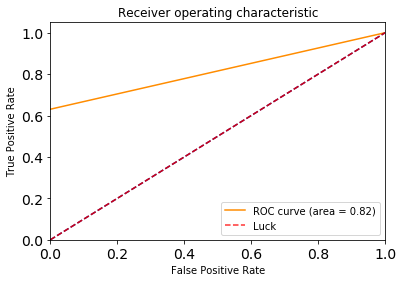

2017-08-05 08:00:00 	refes: 86400 	subjects: 3600 	auc: 0.8152777777777778
accuracy =  0.9726666666666667
auc_score =  0.9595871913580247 	feature importances: [0.24 0.14 0.18 0.16 0.12 0.16]


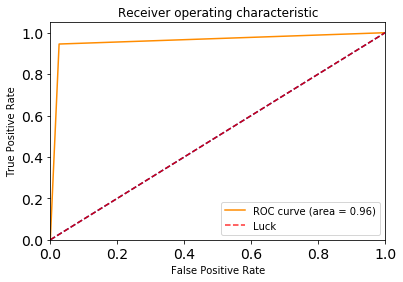

2017-08-05 09:00:00 	refes: 86400 	subjects: 3600 	auc: 0.9595871913580247
accuracy =  0.9594444444444444
auc_score =  0.5103587962962962 	feature importances: [0.16 0.18 0.22 0.1  0.08 0.26]
2017-08-05 10:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5103587962962962
accuracy =  0.959962962962963
auc_score =  0.4999807098765432 	feature importances: [0.22 0.08 0.18 0.18 0.2  0.14]
2017-08-05 11:00:00 	refes: 86400 	subjects: 3600 	auc: 0.4999807098765432
accuracy =  0.9598888888888889
auc_score =  0.49994212962962964 	feature importances: [0.16 0.14 0.28 0.16 0.1  0.16]
2017-08-05 12:00:00 	refes: 86400 	subjects: 3600 	auc: 0.49994212962962964
accuracy =  0.959962962962963
auc_score =  0.4999807098765432 	feature importances: [0.08 0.2  0.12 0.12 0.28 0.2 ]
2017-08-05 13:00:00 	refes: 86400 	subjects: 3600 	auc: 0.4999807098765432
accuracy =  0.959962962962963
auc_score =  0.4999807098765432 	feature importances: [0.12 0.18 0.2  0.28 0.1  0.12]
2017-08-05 14:00:00 	refes: 86400 	subjec

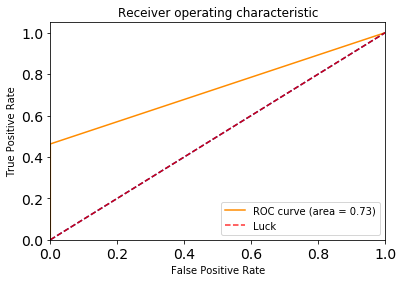

2017-08-05 19:00:00 	refes: 86400 	subjects: 3600 	auc: 0.7314429012345679
accuracy =  0.960037037037037
auc_score =  0.5066743827160494 	feature importances: [0.28 0.04 0.24 0.02 0.22 0.2 ]
2017-08-05 20:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5066743827160494
accuracy =  0.959962962962963
auc_score =  0.4999807098765432 	feature importances: [0.26 0.28 0.06 0.18 0.16 0.06]
2017-08-05 21:00:00 	refes: 86400 	subjects: 3600 	auc: 0.4999807098765432
accuracy =  0.96
auc_score =  0.5 	feature importances: [0.14 0.28 0.2  0.2  0.08 0.1 ]
2017-08-05 22:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
accuracy =  0.96
auc_score =  0.5 	feature importances: [0.12 0.26 0.16 0.16 0.14 0.16]
2017-08-05 23:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
accuracy =  0.959962962962963
auc_score =  0.4999807098765432 	feature importances: [0.06 0.34 0.18 0.18 0.12 0.12]
2017-08-06 00:00:00 	refes: 86400 	subjects: 3600 	auc: 0.4999807098765432
accuracy =  0.96
auc_score =  0.5 	feature importances: 

accuracy =  0.96
auc_score =  0.5 	feature importances: [0.22 0.24 0.12 0.08 0.12 0.22]
2017-08-07 20:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
accuracy =  0.96
auc_score =  0.5 	feature importances: [0.32 0.14 0.04 0.12 0.3  0.08]
2017-08-07 21:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
accuracy =  0.96
auc_score =  0.5 	feature importances: [0.08 0.16 0.22 0.28 0.18 0.08]
2017-08-07 22:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
accuracy =  0.96
auc_score =  0.5 	feature importances: [0.1  0.04 0.2  0.14 0.16 0.36]
2017-08-07 23:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
accuracy =  0.959962962962963
auc_score =  0.4999807098765432 	feature importances: [0.24 0.14 0.14 0.26 0.2  0.02]
2017-08-08 00:00:00 	refes: 86400 	subjects: 3600 	auc: 0.4999807098765432


In [8]:
df['auc_score']=0.5
df['accuracy']=0.96

#find min and max timestamps

start = df.index.min()
end = df.index.max()

#round start 
start.seconds=0
start.minutes=0

ref = window * Hour()
sub = 1 * Hour()

# loop over them
ti=start+ref+sub
count=0
while ti < end + 1 * Minute():
    ref_start = ti-ref-sub
    ref_end = ti-sub
    ref_df = df[(df.index >= ref_start) & (df.index < ref_end)]
    sub_df = df[(df.index >= ref_end) & (df.index < ti)]
    
    auc_score, accuracyscore = check_for_anomaly(ref_df, sub_df)
    df.loc[(df.index>=ref_end) & (df.index<=ti),['auc_score']] = auc_score
    
    #accuracyscore = check_for_anomaly(ref_df, sub_df)
    df.loc[(df.index>=ref_end) & (df.index<=ti),['accuracy']] = accuracyscore
    
    print(ti,"\trefes:" , ref_df.shape[0], "\tsubjects:", sub_df.shape[0], '\tauc:', auc_score)
    ti = ti + sub
    count=count+1
    #if count>2: break
    


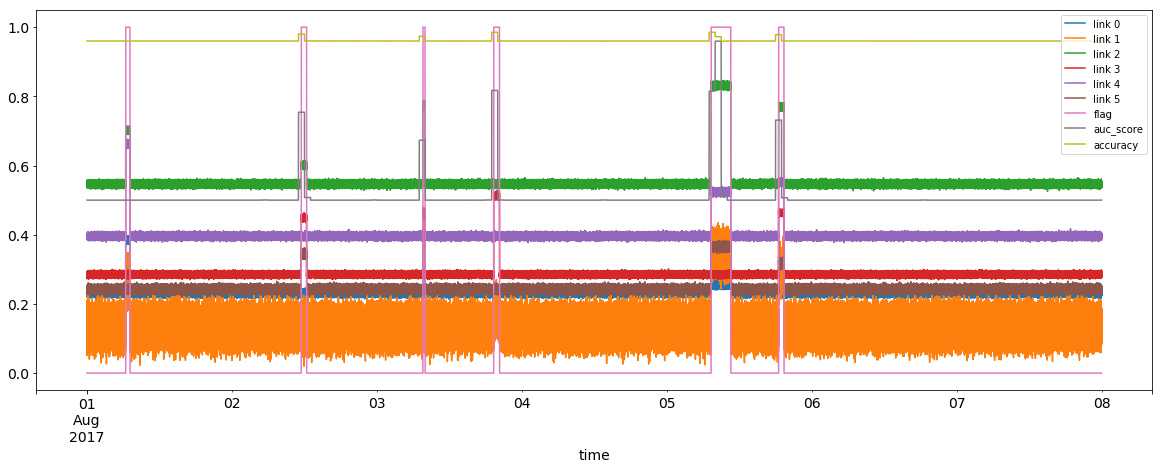

In [9]:
ax = df.plot(figsize=(20,7))
ax.set_xlabel("time", fontsize=14)

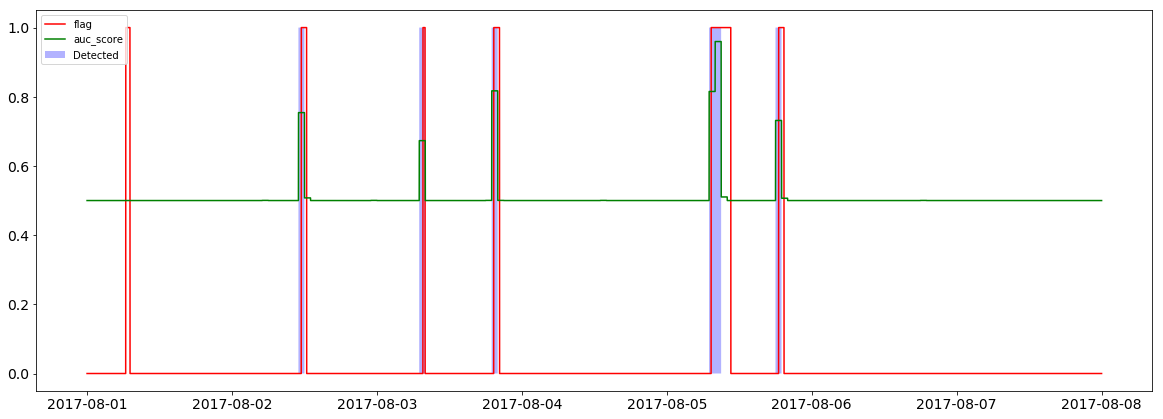

In [10]:
fig, ax = plt.subplots(figsize=(20,7))
df.loc[:,'Detected'] = 0
df.loc[df.auc_score>0.55,'Detected']=1
df.head()
ax.plot(df.flag, 'r')
ax.plot(df.auc_score,'g')
ax.fill( df.Detected, 'b', alpha=0.3)
ax.legend(loc='upper left')
plt.show()

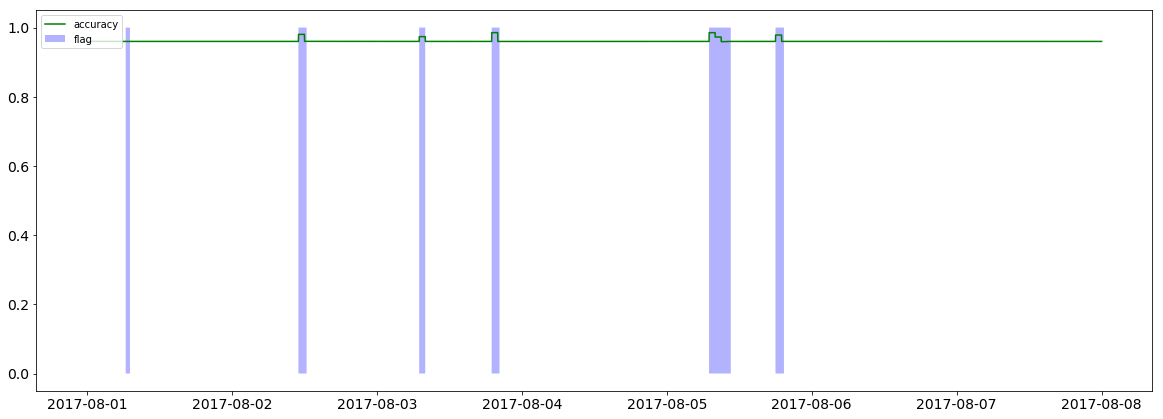

In [11]:
fig, ax = plt.subplots(figsize=(20,7))
#df.loc[:,'Detected'] = 0.96
#df.loc[df.auc_score>0.55,'Detected']= 1
#df.loc[:,'flag'] = 0.96
df.loc[df.auc_score>0.55,'flag']= 1
df.head()

#ax.fill(df.flag, 'r')
#df.loc[:,'flag'] = 0.96
#df.loc[df.flag>0.96,'flag']= 1
#ax.fill(df.flag, 'r', alpha=0.3)

ax.plot(df.accuracy,'g')
#ax.fill( df.Detected, 'b', alpha=0.3)
ax.fill( df.flag, 'b', alpha=0.3)
ax.legend(loc='upper left')
plt.show()

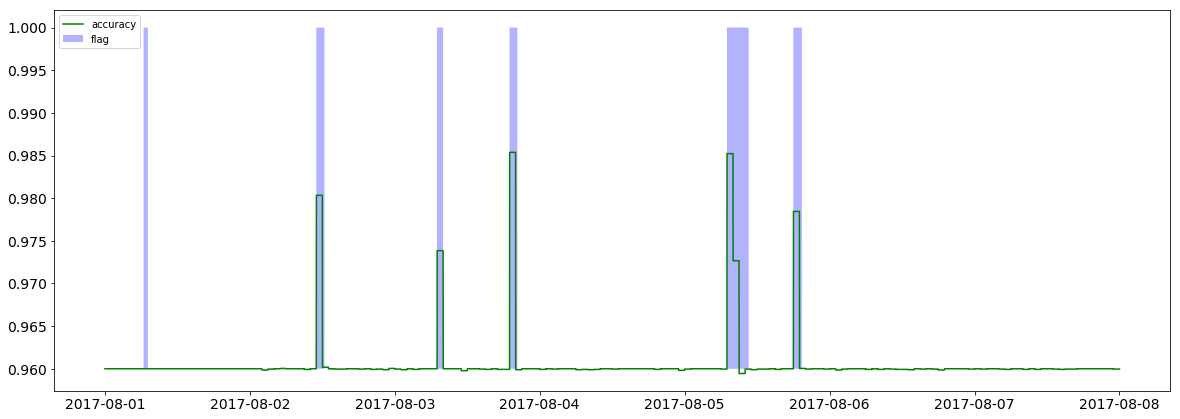

In [12]:
fig, ax = plt.subplots(figsize=(20,7))
df.loc[df.flag<0.1,'flag']= 0.96
df.head()

ax.plot(df.accuracy,'g')
ax.fill( df.flag, 'b', alpha=0.3)
ax.legend(loc='upper left')
plt.show()

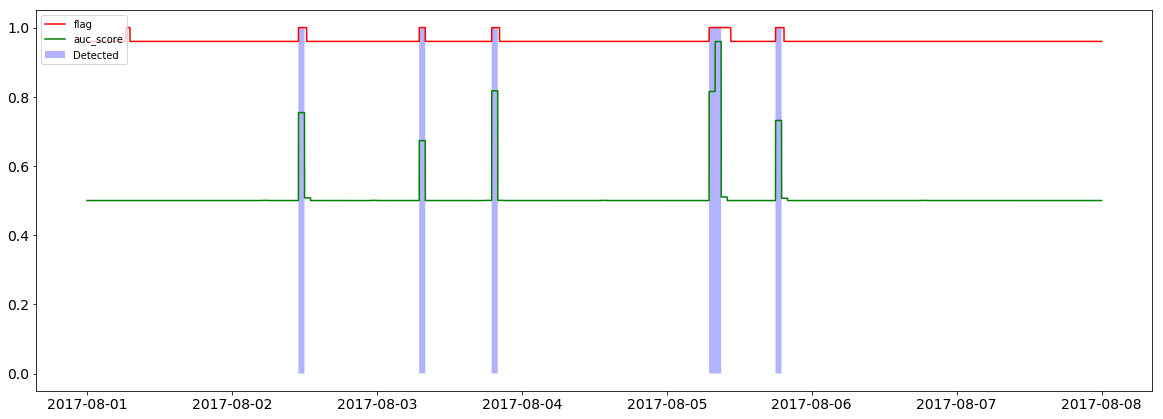

In [13]:
fig, ax = plt.subplots(figsize=(20,7))
df.loc[:,'Detected'] = 0
df.loc[df.auc_score>0.55,'Detected']=1
df.head()
ax.plot(df.flag, 'r')
ax.plot(df.auc_score,'g')
ax.fill( df.Detected, 'b', alpha=0.3)
ax.legend(loc='upper left')
plt.show()

In [40]:
import numpy as np
from scipy.stats import binom
from matplotlib import pyplot as plt

n = 100
p = 0.5
k = df.accuracy
#print(k)
binomial = binom.pmf(k, n, p)
binomial

NameError: name 'random' is not defined

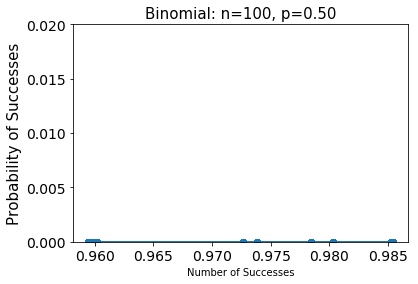

In [38]:
plt.plot(k, binomial, 'o-')
plt.title('Binomial: n=%i, p=%.2f' % (n,p), fontsize = 15)
plt.xlabel('Number of Successes')
plt.ylabel('Probability of Successes', fontsize = 15)
plt.ylim([0,0.02])
plt.show()

In [35]:
print(df.accuracy)
list345 = df['accuracy'].values.tolist()

2017-08-01 00:00:00    0.960000
2017-08-01 00:00:01    0.960000
2017-08-01 00:00:02    0.960000
2017-08-01 00:00:03    0.960000
2017-08-01 00:00:04    0.960000
2017-08-01 00:00:05    0.960000
2017-08-01 00:00:06    0.960000
2017-08-01 00:00:07    0.960000
2017-08-01 00:00:08    0.960000
2017-08-01 00:00:09    0.960000
2017-08-01 00:00:10    0.960000
2017-08-01 00:00:11    0.960000
2017-08-01 00:00:12    0.960000
2017-08-01 00:00:13    0.960000
2017-08-01 00:00:14    0.960000
2017-08-01 00:00:15    0.960000
2017-08-01 00:00:16    0.960000
2017-08-01 00:00:17    0.960000
2017-08-01 00:00:18    0.960000
2017-08-01 00:00:19    0.960000
2017-08-01 00:00:20    0.960000
2017-08-01 00:00:21    0.960000
2017-08-01 00:00:22    0.960000
2017-08-01 00:00:23    0.960000
2017-08-01 00:00:24    0.960000
2017-08-01 00:00:25    0.960000
2017-08-01 00:00:26    0.960000
2017-08-01 00:00:27    0.960000
2017-08-01 00:00:28    0.960000
2017-08-01 00:00:29    0.960000
                         ...   
2017-08-

In [17]:
print("Hi")

Hi
